In [222]:
import json
import os
import sys
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy

sys.path.append("../../")
import didgelab.calc.fft
from didgelab.calc.sim.sim import *
from didgelab.calc.fft import *
from didgelab.app import get_app
from didgelab.initializer import init_console_no_output
from didgelab.calc.geo import Geo
from collections import defaultdict

init_console_no_output()

da_path = "/Users/jane03/workspaces/music/didge/didge-archive"
didge_archive = json.load(open(os.path.join(da_path, "didge-archive.json")))
didge_archive = list(filter(lambda x:x["shape"] == "straight", didge_archive))


In [122]:
# find peaks in audio files and in the acoustic simulation
# goal: generate training data for the algorithm

def minmax(a):
    a -= a.min()
    a /= a.max()
    return a

fmin=1
fmax=1000
def sling_window_average_spectrum(freq, spectrum, window_size=5):
    new_freqs = []
    new_spectrum = []
    
    for i in np.arange(window_size, len(freq), window_size):
        new_freqs.append(freq[i])
        new_spectrum.append(np.mean(spectrum[i-window_size:i]))
    return np.array(new_freqs), np.array(new_spectrum)


def get_fundamental(fft_freq, fft):
    i = scipy.signal.argrelextrema(fft, np.greater, order=40)
    freqs = fft_freq[i]
    freqs = freqs[freqs>50]
    freqs = freqs[freqs<120]
    assert len(freqs) == 1

    fundamental_freq = freqs[0]
    fundamental_freq_i = np.argmin(np.abs(fft_freq-fundamental_freq))
    return fundamental_freq, fundamental_freq_i

def get_peaks(fft_freq, fft):
    fundamental_freq, fundamental_freq_i = get_fundamental(fft_freq, fft)
    order = 1
    while fft_freq[fundamental_freq_i+order] < fundamental_freq*1.3:
        order += 1
    peaks = [fundamental_freq]
    for i in scipy.signal.argrelextrema(fft, np.greater, order=order)[0]:
        freq = fft_freq[i]
        if freq>fundamental_freq:
            peaks.append(freq)
    return np.array(peaks)

def get_training_data(didge_archive):

    data = defaultdict(list)

    for didge in didge_archive:
        infile = os.path.join(da_path, didge["audio-samples"]["neutral-sound"])
        fft_freq, fft = do_fft(infile)
        fft = np.log2(fft)
        fft = minmax(fft)
        #fft_freq, fft = sling_window_average_spectrum(fft_freq, fft, window_size=1)
        fft = fft/fft.max()

        geofile = os.path.join(da_path, didge["geometry"])
        geo = json.load(open(geofile))
        geo = Geo(geo)
        freqs = get_log_simulation_frequencies(fmin, fmax, 1)
        segments = create_segments(geo)
        impedance = compute_impedance(segments, freqs)
        ground_freqs, imp_ip = interpolate_spectrum(freqs, impedance)
        ground = compute_ground_spektrum(ground_freqs, imp_ip)
        ground /= ground.max()
        
        measured_peaks = get_peaks(fft_freq, fft)
        predicted_peaks = get_peaks(ground_freqs, ground)

        predicted = []
        measured = []
        for i_pp in range(len(predicted_peaks)):
            pp = predicted_peaks[i_pp]
            next_i = np.argmin(np.abs(pp-measured_peaks))
            if len(measured)>0 and measured[-1] == next_i:
                dist1 = np.abs(predicted_peaks[measured[-1]]-measured_peaks[next_i])
                dist2 = np.abs(pp-measured_peaks[next_i])
                
                if dist2<dist1:
                    measured[-1] = next_i
                    predicted[-1] = i_pp
            else:
                    measured.append(next_i)
                    predicted.append(i_pp)
                
        assert len(measured) == len(predicted)
        measured_peaks = measured_peaks[measured]
        predicted_peaks = predicted_peaks[predicted]

        for i in range(len(measured_peaks)):
            data["measured"].append(measured_peaks[i])
            data["predicted"].append(predicted_peaks[i])
            data["didge"].append(didge["name"])

    return pd.DataFrame(data)

data = get_training_data(didge_archive)
data["delta"] = data.predicted - data.measured
data


,measured,predicted,didge,delta
0,93.957447,93,Malveira,-0.957447
1,188.595745,183,Malveira,-5.595745
2,282.553191,277,Malveira,-5.553191
3,376.510638,367,Malveira,-9.510638
4,471.148936,461,Malveira,-10.148936
...,...,...,...,...
84,659.154437,656,Matema,-3.154437
85,732.774284,731,Matema,-1.774284
86,806.394130,802,Matema,-4.394130
87,864.605171,875,Matema,10.394829


[Text(0.5, 0, 'frequency'), Text(0, 0.5, 'error')]

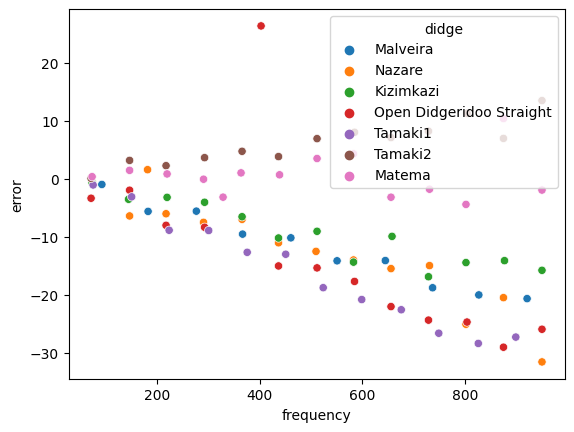

In [223]:
ax=sns.scatterplot(data=data, x="predicted", y="delta", hue="didge")
ax.set(xlabel='frequency', ylabel='error')

In [224]:
# train a linear regression
# and evaluate it

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR

dfs = []

def model_without_didge(didge):
    train_data = data.query("didge!=@didge")
    x_train=train_data.predicted.to_numpy().reshape((len(train_data),1))
    y_train=train_data.measured.to_numpy().reshape((len(train_data),1))
    x_train = np.log2(x_train)
    y_train = np.log2(y_train)
    model = LinearRegression().fit(x_train, y_train)
    return model

def compute_correction(model, freqs):
    freqs = np.log2(freqs).reshape(len(freqs), 1)
    correction = model.predict(freqs).reshape(len(freqs))
    correction = np.power(2, correction)
    return correction

for didge in data.didge.unique():
    model = model_without_didge(didge)

    test_x = data.query("didge==@didge").predicted.to_numpy()
    y_true = data.query("didge==@didge").measured.to_numpy()

    corrected_prediction = compute_correction(model, test_x)
    df = {"measured": y_true, "predicted": test_x, "corrected": corrected_prediction}
    df = pd.DataFrame(df)
    df["didge"] = didge
    df["delta_vorher"] = df.measured - df.predicted
    df["delta_nachher"] = df.measured - df.corrected
    dfs.append(df)


dfs = pd.concat(dfs)
print(f"delta vorher: {dfs.delta_vorher.mean():.2f}")
print(f"delta vorher: {dfs.delta_nachher.mean():.2f}")

eval_per_didge = defaultdict(list)
for didge in dfs.didge.unique():
    df = dfs.query("didge==@didge")

    measured = np.log2(df.measured)
    predicted = np.log2(df.predicted)
    corrected = np.log2(df.corrected)

    error_vorher = np.abs(measured-predicted).mean()
    error_nachher = np.abs(measured-corrected).mean()

    eval_per_didge["didge"].append(didge)
    eval_per_didge["improvmenet"].append(error_vorher - error_nachher)
    #eval_per_didge["error_nachher"].append(error_nachher)

eval_per_didge = pd.DataFrame(eval_per_didge)
eval_per_didge.round(2)
#    print(didge)
#dfs.groupby("didge").delta_nachher.mean()

delta vorher: 7.70
delta vorher: 0.07


,didge,improvmenet
0,Malveira,0.02
1,Nazare,0.02
2,Kizimkazi,0.02
3,Open Didgeridoo Straight,0.02
4,Tamaki1,0.02
5,Tamaki2,-0.03
6,Matema,-0.02


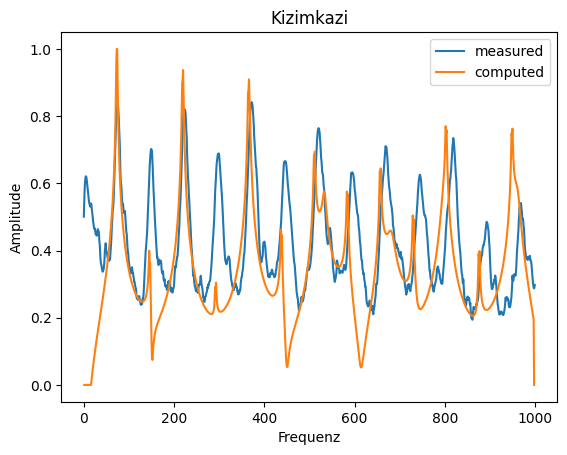

In [242]:
# plot measured, computed and corrected fft spectrum for a single didgeridoo

from scipy.signal import savgol_filter

didge = didge_archive[2]
infile = os.path.join(da_path, didge["audio-samples"]["neutral-sound"])
fft_freq, fft = do_fft(infile)
fft = np.log2(fft)
fft = minmax(fft)
fft = fft/fft.max()
fft_smooth = savgol_filter(fft, 20, 3) # window size 51, polynomial order 3

geofile = os.path.join(da_path, didge["geometry"])
geo = json.load(open(geofile))
geo = Geo(geo)
freqs = get_log_simulation_frequencies(fmin, fmax, 1)
segments = create_segments(geo)
impedance = compute_impedance(segments, freqs)
ground_freqs, imp_ip = interpolate_spectrum(freqs, impedance)
ground = compute_ground_spektrum(ground_freqs, imp_ip)
ground /= ground.max()

measured_peaks = get_peaks(fft_freq, fft)
predicted_peaks = get_peaks(ground_freqs, ground)

correction_model = model_without_didge(didge["name"])
corrected_freqs = compute_correction(correction_model, ground_freqs)


plt.plot(fft_freq, fft_smooth, label="measured")
plt.plot(ground_freqs, ground, label="computed")
#plt.plot(corrected_freqs, ground, label="corrected")
plt.title(didge["name"])
plt.xlabel("Frequenz")
plt.ylabel("Amplitude")
plt.legend()

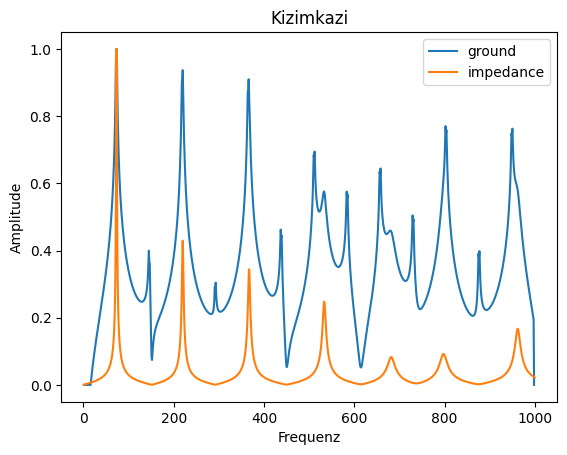

In [243]:
#plt.plot(fft_freq, fft_smooth, label="measured")
plt.plot(ground_freqs, ground, label="ground")
#ground_freqs2, imp_ip = interpolate_spectrum(freqs, impedance)
plt.plot(freqs, impedance/impedance.max(), label="impedance")
#plt.plot(corrected_freqs, ground, label="corrected")
plt.title(didge["name"])
plt.xlabel("Frequenz")
plt.ylabel("Amplitude")
plt.legend()

In [244]:
# train a model and save it for later use outside of this notebook

from joblib import dump, load

x_train=data.predicted.to_numpy().reshape((len(data),1))
y_train=data.measured.to_numpy().reshape((len(data),1))
model = LinearRegression().fit(x_train, y_train)

outfile = "../../../assets/correction_models/2024-03-18-linear-regression.joblib"
dump(model, outfile) 

['../../../assets/correction_models/2024-03-18-linear-regression.joblib']